## PySM 3 dust model based on Planck GNILC maps
tags: [pysm,healpy,cosmology]

The purpose of this notebook is to pre-process galactic dust maps from the [Planck analysis with GNILC](https://arxiv.org/abs/1605.09387)
to create a dust model for PySM 3 which is based on real data at large scale and has added gaussian fluctuations at small scales.

These dust maps, compared to the commander results used by the `d1` model of PySM 2, have the CIB signal removed.
Also, on top of smoothing the input templates to remove noise from Planck as was done in PySM 2,
we also want to smooth the spectral index map and the dust temperature map.

In [1]:
import os
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [2]:
hp.disable_warnings()

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 2048
degraded_nside = 2048 # to speedup notebook for testing
lmax = 1000

## Masks

Using the Planck Common mask for polarization from the 3rd release:

https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/previews/COM_Mask_CMB-common-Mask-Pol_2048_R3.00/index.html

In [6]:
planck_mask_filename = "COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits"

In [7]:
if not os.path.exists(planck_mask_filename):
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/$planck_mask_filename

In [8]:
fits.open(planck_mask_filename)[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    4 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
COMMENT  -------------------------------------------------------------          
COMMENT  Further details in the Planck Legacy Archive and Explanatory Supplement
COMMENT  http://www.cosmos.esa.int/web/planck/pla/                              
COMMENT  -------------------------------------------------------------          
COMMENT                     

In [9]:
planck_mask = hp.read_map(planck_mask_filename)

In [10]:
if degraded_nside != nside:
    planck_mask = hp.ud_grade(planck_mask, degraded_nside) == 1

In [11]:
np.unique(planck_mask) # no apodization

array([0., 1.])

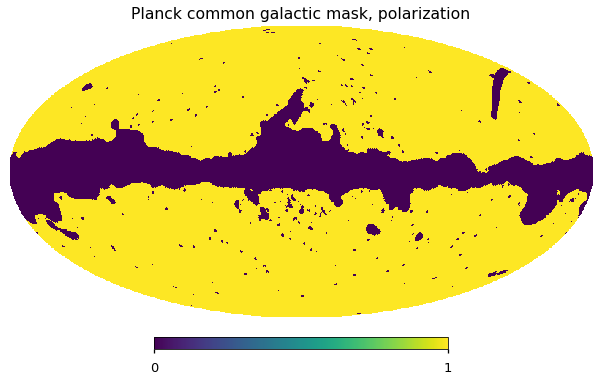

In [12]:
hp.mollview(planck_mask, title="Planck common galactic mask, polarization")

## Planck GNILC dust polarization

Downloaded from the Planck Legacy Archive (PLA), the [GNILC templates](https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Foreground_maps#GNILC_thermal_dust_maps) are available either at a single resolution of 80 arcminutes or at variable resolution, where regions of higher emission have 5 arcmin resolution. Here we want to fit the slope of the small scales therefore we want the variable resolution image which has the least smoothing applied.

In [13]:
dust_map_filename = "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

In [14]:
if not os.path.exists(dust_map_filename):
    !wget -O $dust_map_filename http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=$dust_map_filename

In [15]:
fits.open(dust_map_filename).info()

Filename: COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     71   50331648R x 10C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [16]:
m_planck,h = hp.read_map(dust_map_filename, ("Q_STOKES", "U_STOKES"), h=True)

In [17]:
if degraded_nside != nside:
    m_planck = hp.ud_grade(m_planck, degraded_nside)

In [18]:
h

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 40),
 ('NAXIS2', 50331648),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 10),
 ('COMMENT', ' -------------------------------------------------------------'),
 ('COMMENT', ' Products from GNILC component separation method'),
 ('COMMENT', ' -------------------------------------------------------------'),
 ('COMMENT',
  ' Further details in the Planck Legacy Archive and Explanatory Supplement'),
 ('COMMENT', ' http://www.cosmos.esa.int/web/planck/pla/'),
 ('COMMENT', ' -------------------------------------------------------------'),
 ('COMMENT', ''),
 ('COMMENT', ' *** Planck params ***'),
 ('COMMENT', ''),
 ('EXT-NAME', 'COMP-MAP'),
 ('AST-COMP', 'THERMAL DUST'),
 ('PIXTYPE', 'HEALPIX'),
 ('COORDSYS', 'GALACTIC'),
 ('POLCCONV', 'COSMO'),
 ('ORDERING', 'NESTED'),
 ('NSIDE', 2048),
 ('METHOD', 'GNILC'),
 ('UNITFREQ', 'GHz'),
 ('BANDCTR', 353.0),
 ('RESTFREQ', 353.0),
 ('BNDWID', 0.0),
 ('BAD_DATA', -1.6375e+30),
 ('DATE'

Input units are $K_{CMB}$, PySM templates use $\mu K_{RJ}$

In [19]:
m_planck <<= u.K_CMB

In [20]:
m_planck = m_planck.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))

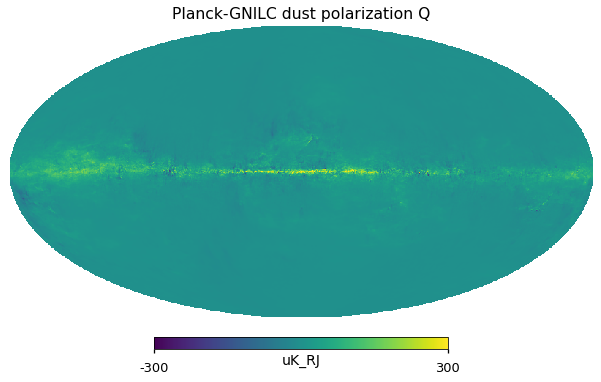

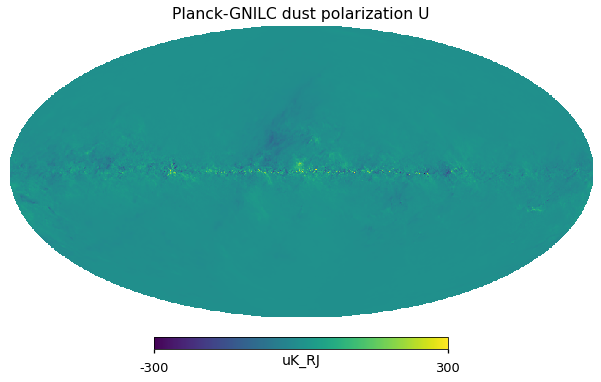

In [21]:
for i_pol, pol in [(0, "Q"), (1, "U")]:
    hp.mollview(m_planck[i_pol], title="Planck-GNILC dust polarization " + pol, unit=m_planck.unit, min=-300, max=300)

## Angular power spectrum with `namaster`

We use `namaster` to estimate the power spectrum of the masked map,
compared to `anafast`, `namaster` properly deconvolves the mask to remove the
correlations between different $C_\ell$ caused by the mask.

We don't need to deconvolve the beam, we won't be using the values at high $\ell$ anyway.

In [22]:
import pymaster as nmt

In [23]:
f_2 = nmt.NmtField(planck_mask, m_planck)

In [24]:
binning = nmt.NmtBin(nside=degraded_nside, nlb=1, lmax=lmax, is_Dell=False)

In [25]:
cl_namaster = nmt.compute_full_master(f_2, f_2, binning)

In [26]:
hp.write_cl("cl_gnilc_varres.fits", cl_namaster, overwrite=True)
# cl_namaster = hp.read_cl("cl_gnilc_varres.fits")

In [27]:
cl = {}
cl["EE"] = np.concatenate([[0,0], cl_namaster[0]])
cl["BB"] = np.concatenate([[0,0], cl_namaster[3]])

In [28]:
ell = np.concatenate([[0,0], binning.get_effective_ells()])
cl_norm = ell*(ell+1)/np.pi/2

The maps are smoothed (with different beams in different regions), so we try to select the region of $\ell$ which is roughtly linear in `loglog` scale just before the curvature of the smoothing looks to start dominating. We will use this region to fit to extrapolate small scale power to high $\ell$.

In [29]:
ell_fit_low = 100
ell_fit_high = 300
ell_star = 100

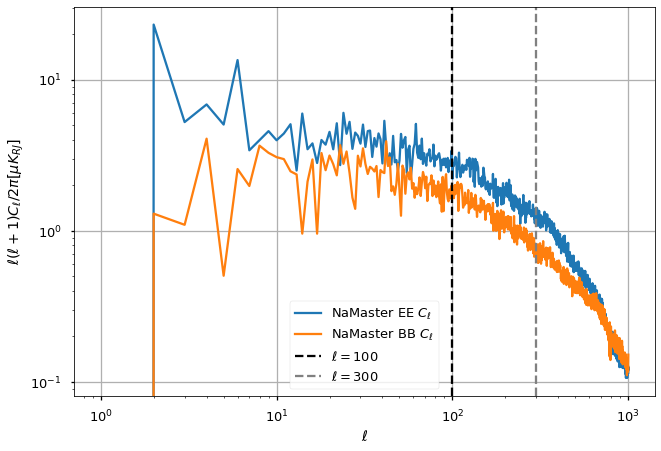

In [30]:
plt.loglog(cl_norm * cl["EE"], label="NaMaster EE $C_\ell$")
plt.loglog(cl_norm * cl["BB"], label="NaMaster BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
plt.legend()
plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))
plt.grid();

In [31]:
from scipy.optimize import curve_fit

In [32]:
def model(ell, A, gamma):
    return A * ell ** gamma

In [33]:
xdata = np.arange(ell_fit_low, ell_fit_high)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


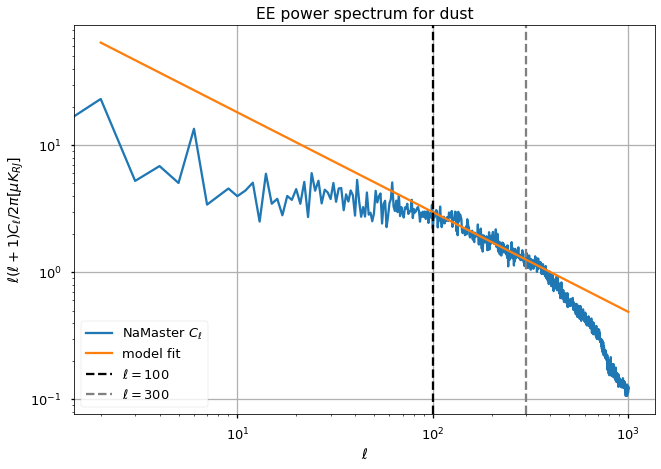

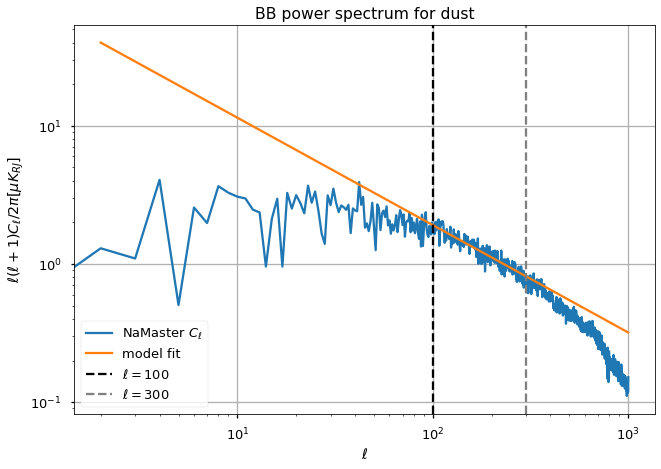

In [34]:
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
for pol,i_pol in [("EE",0),("BB",3)]:
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.figure()
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell$")
    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_sigma_G[pol], label="SS $C_\ell$")

    plt.loglog(ell, A_fit[pol]*ell**gamma_fit[pol], label="model fit")
    plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
    plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust")
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    #plt.xlim(0, 400)
    #plt.ylim(1, 30);

In [35]:
A_fit, A_fit_std

({'EE': 110.69948374652381, 'BB': 68.67547785532432},
 {'EE': 13.964295124848087, 'BB': 7.874749558104543})

In [36]:
gamma_fit, gamma_fit_std

({'EE': -0.7851635603628481, 'BB': -0.7776591692375737},
 {'EE': 0.02471765035659503, 'BB': 0.0224620039874886})

In the PySM 2 paper the slopes where: $\gamma^{EE,dust} = -.31$ and $\gamma^{BB,dust} = -.15$.

## Load the smoothed GNILC map

Now that we have fitted the small scales behaviour on the GNILC map at higher resolution, we load the GNILC smoothed map,
at 80 arcminutes and fill in the small scale fluctiaitons on that map.

In [37]:
dust_map_smoothed_filename = "COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits"

In [38]:
if not os.path.exists(dust_map_smoothed_filename):
    !wget -O $dust_map_filename http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=$dust_map_smoothed_filename

In [39]:
m_planck_smoothed = hp.read_map(dust_map_smoothed_filename, (0,1,2))

In [40]:
m_planck_smoothed[0] = 0

In [41]:
m_planck_smoothed <<= u.K_CMB

In [42]:
m_planck_smoothed = m_planck_smoothed.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))

### Window function

The window function is used to smooth the input templates to remove the high $\ell$ noise and its inverse is used for the added small scales.

In the PySM 2 paper, smoothing was at 2.6 degrees. Here we just use the GNILC map at uniform resolution of 80 arcminutes.

In [43]:
theta_fwhm_deg = 80/60 # 80 arcmin

In [44]:
theta_fwhm_deg

1.3333333333333333

In [45]:
180/theta_fwhm_deg

135.0

In [46]:
theta_fwhm = np.radians(theta_fwhm_deg)

In [47]:
w_ell = hp.gauss_beam(fwhm=theta_fwhm, lmax=lmax)

In [48]:
w_ell.shape

(1001,)

In [49]:
inv_w_ell = 1 - w_ell**2

(0.01, 100.0)

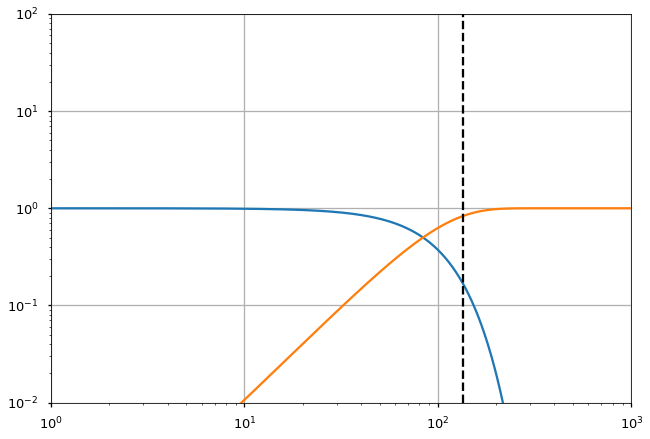

In [50]:
plt.loglog(w_ell**2)
plt.loglog(inv_w_ell)
plt.axvline(180/theta_fwhm_deg, color="black", linestyle="--")
plt.grid()
plt.xlim([1,1000])
plt.ylim([1e-2, 1e2])

## Simulate a realization of small scales fluctuations

We simulate small scales fluctuations using the inverse of the window function and the fitted amplitude and slope.
Also fix the seed to make this reproducible.

In [51]:
np.random.seed(777)

In [52]:
zeros = np.zeros(len(ell), dtype=np.double)

In [53]:
m_sigma_G = hp.synfast([
    zeros,
    A_fit["EE"] * ell**gamma_fit["EE"] * inv_w_ell / cl_norm,
    A_fit["BB"] * ell**gamma_fit["BB"] * inv_w_ell / cl_norm,
    zeros, zeros, zeros], nside, new=True)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


## Write output map

We write the output map, GNILC smoothed at 80 arcmin + the small scale fluctuations

In [54]:
m_total = m_planck_smoothed.value + m_sigma_G

In [55]:
m_total[0] = 0

In [56]:
hp.write_map("gnilc_plus_smallscales.fits", m_total, overwrite=True)

## Scale the small scale fluctuations with large scale amplitude

As described in the PySM 2 paper, we compute the power spectrum in every patch e.g. pixel at $N_{side}=2$, and then scale the small scale fluctuations so that they agree with the power at large scale (we use a specific $\ell$ to make the comparison, in the paper it is 69, here we are doing less smoothing so we use a higher ell, see `ell_star`.

This process doesn't have a large impact on the output spectra, the idea is that in each $N_{side}=2$ pixel we want to scale the gaussian fluctuations so that they are consistent with the power at low ell.
So we will have higher gaussian fluctuations on the galaxy where there is stronger dust emission.

$$
N(\boldsymbol{\hat{n}}) = \sqrt{\dfrac{C_{\ell_*}(\boldsymbol{\hat{n}})}{A\ell_*^\gamma}}
$$

In [57]:
ell_star

100

In [58]:
patch_indices = hp.ud_grade(np.arange(hp.nside2npix(2)), nside)

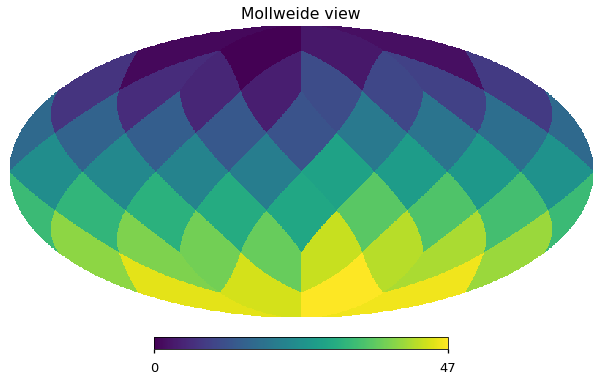

In [59]:
hp.mollview(patch_indices)

In [60]:
nside_patches = 2
n_patches = hp.nside2npix(nside_patches)

In [61]:
N = {i_pol:np.zeros(n_patches, dtype=np.double) for i_pol in [1,2]}

In [62]:
for i_patch in range(n_patches):
    print(i_patch)
    m_patch = np.zeros_like(m_planck_smoothed)
    m_patch[1:, patch_indices == i_patch] = m_planck_smoothed[1:, patch_indices == i_patch]
    cl_patch = hp.anafast(m_patch, lmax=2*ell_star, use_pixel_weights=True)
    for pol,i_pol in [("EE", 1),("BB",2)]:
        N[i_pol][i_patch] = np.sqrt(cl_patch[i_pol][ell_star] / n_patches / (A_fit[pol] * ell_star ** gamma_fit[pol]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


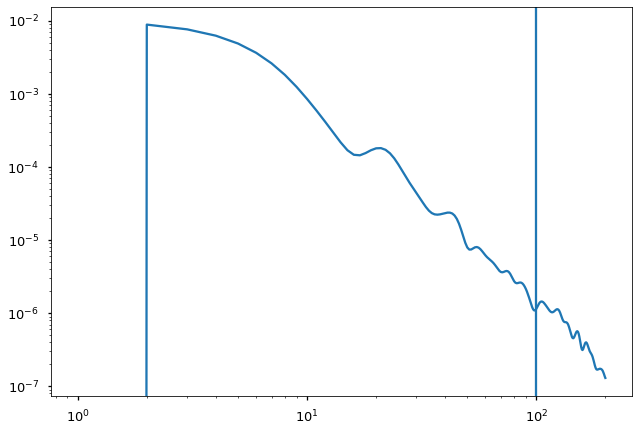

In [63]:
plt.loglog(cl_patch[1])
plt.axvline(ell_star)

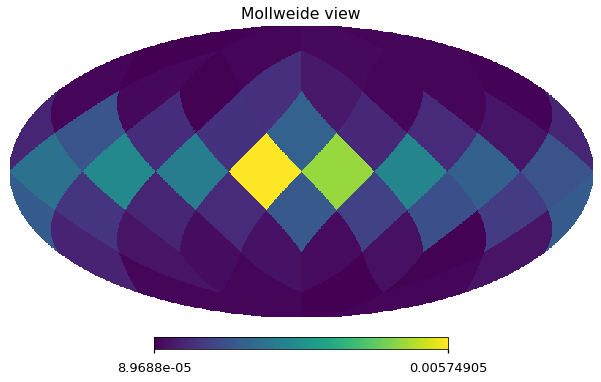

In [64]:
hp.mollview(N[1])

In [65]:
m_zeros = np.zeros(hp.nside2npix(nside), dtype=np.double)

In [66]:
hp.write_map("N.fits", [np.zeros(len(N[1])), N[1], N[2]], overwrite=True)

In [67]:
# N = hp.read_map("N.fits", (0,1,2))

In [69]:
N_smoothed = hp.smoothing([m_zeros, hp.ud_grade(N[1], nside), hp.ud_grade(N[2], nside)], fwhm=np.radians(10))

In [70]:
hp.write_map("N_smoothed.fits", N_smoothed, overwrite=True)
# N_smoothed = hp.read_map("N_smoothed.fits", (0,1,2))

In [71]:
N_smoothed[1] /= (N_smoothed[1]).mean()

In [72]:
N_smoothed[2] /= (N_smoothed[2]).mean() 

In [73]:
hp.write_map("N_smoothed_normalized.fits", N_smoothed, overwrite=True)
# N_smoothed = hp.read_map("N_smoothed.fits", (0,1,2))

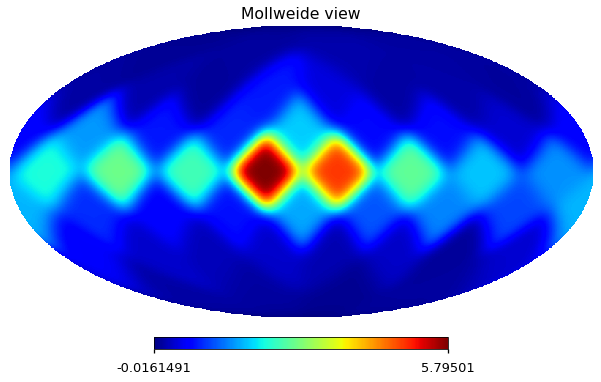

In [74]:
hp.mollview(N_smoothed[1], cmap="jet")

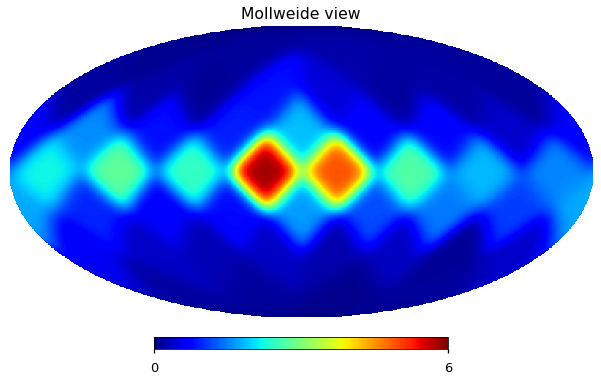

In [75]:
hp.mollview(N_smoothed[1], min=0, max=6, cmap="jet")

In [76]:
m_total = m_planck_smoothed.value + m_sigma_G * N_smoothed

In [77]:
m_total[0] = 0

In [78]:
hp.write_map("gnilc_plus_smallscales_scaled.fits", m_total, overwrite=True)

# 